## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install keras_self_attention
!pip install keras_layer_normalization
!pip install pyvi

  Created wheel for keras-self-attention: filename=keras_self_attention-0.42.0-cp36-none-any.whl size=17296 sha256=3bfc5a5fdf175f57565a31644c038fd6f516fbc622d470a35b5eece1cf24f999
  Stored in directory: /root/.cache/pip/wheels/7b/05/a0/99c0cf60d383f0494e10eca2b238ea98faca9a1fe03cac2894
Successfully built keras-self-attention
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.14.0-cp36-none-any.whl size=5268 sha256=93be0f8d526e8d9653fe247e90a55b973f649b8d2654420c5ee8419cf33effb7
  Stored in directory: /root/.cache/pip/wheels/54/80/22/a638a7d406fd155e507aa33d703e3fa2612b9eb7bb4f4fe667
Successfully built keras-layer-normalization
     |████████████████████████████████| 8.8MB 3.1MB/s 
     |████████████████████████████████| 757kB 35.0MB/s 


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pyvi import ViTokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import random
import pickle
import json
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [0]:
ROOT_PATH = '/content/drive/My Drive/Colab Notebooks (1)/sentiment_analysis/'

## Load and process data

In [5]:
train = pd.read_csv(ROOT_PATH + 'data/train_add_gen.csv', encoding='utf-16')
print(train.shape)
train.head()

(10187, 2)


,content,ground
0,Đôi khi màn hình chạy chậm...Vào mạng nhanh nó...,0
1,Dùng tốt nhưng thiếu 4g và bộ nhớ hơi kém và m...,0
2,Vào các ứng dụng hầu như rất chậm. Chơi game n...,0
3,Giảm gần 1 nữa lúc mua. F9 ra còn rẻ hơn f7 lú...,0
4,"Đã mua và sử dụng được 2 tháng, rất tuyệt. Xài...",1


In [6]:
test = pd.read_csv(ROOT_PATH + 'data/test.csv', encoding='utf-16')
print(test.shape)
test.head()

(1552, 2)


,content,ground
0,Sản phẩm hay bị đơ! Dùng pin 4g hao nhanh. Hỗ ...,0
1,"Đẹp nhất, cấu hình cao nhất, pin trâu nhất tro...",1
2,"Trên cả tuyệt vời 😍 pin trâu, mượt, sang trọng...",1
3,Sản phẩm tầm trung Xài tạm ổn. Nói chung sản p...,0
4,oppo neo 7 thật quá đã. Tính năng cũng như HĐH...,1


In [0]:
def text_normalize(df, tokenize=False):
    # Convert text to lowercase
    df['content'] = df['content'].str.lower()
    # Remove numbers and words with numbers
    df['content'] = df['content'].str.replace('\w*\d\w*', ' ')
    # Remove punctuation
    df['content'] = df['content'].str.replace('[^\w\s]', ' ')
    # Remove whitespaces
    df['content'] =  df['content'].str.split().apply(lambda x : ' '.join(word for word in x))
    # Tokenize
    if tokenize:
        df['content'] = df['content'].apply(lambda x : ViTokenizer.tokenize(x))

In [8]:
text_normalize(train)
text_normalize(test)
test.tail()

,content,ground
1547,máy mình dùng một thời gian ngắn nhưng chậm sử...,0
1548,cho đến hôm nay máy vẫn bị loạn cảm ứng cập nh...,0
1549,đẹp chuẩn sài rất êm tôi rất hài lòng về dòng ...,1
1550,mặc dù mua máy cũ nhưng trông như máy mới mọi ...,1
1551,máy chạy tốt mình hài lòng mua từ tháng năm tớ...,0


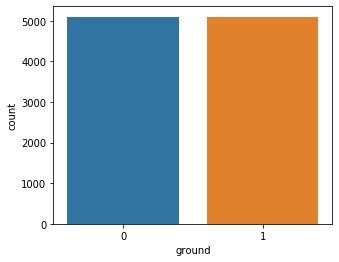

In [0]:
plt.figure(figsize = (5, 4))
sns.countplot(train.ground)
plt.show()

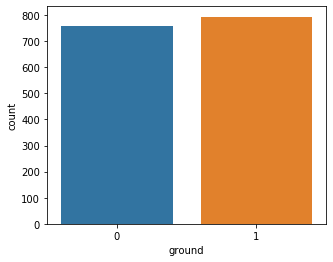

In [0]:
plt.figure(figsize = (5, 4))
sns.countplot(test.ground)
plt.show()

## Word Embedding

In [9]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(ROOT_PATH + 'resource/cc.vi.300.vec', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 2000000 word vectors.


In [0]:
def make_padded_docs(texts, max_length, tokenizer=None):
    if tokenizer == None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(texts)
    vocab_size = len(tokenizer.word_index) + 1
    # integer encode the documents
    encoded_docs = tokenizer.texts_to_sequences(texts)
    # print(encoded_docs)
    # pad documents to a max length of 4 words
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post', truncating='post')
    print(f'padded_docs shape: {padded_docs.shape}')

    return padded_docs, vocab_size, tokenizer

In [0]:
def make_weight_matrix(embeddings_index, vocab_size, dim, tokenizer):
    # create a weight matrix for words in training docs
    embedding_matrix = np.zeros((vocab_size, dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print(f'embedding_matrix shape: {embedding_matrix.shape}')

    return embedding_matrix

In [12]:
labels = np.array(train.ground)
Counter(labels)

Counter({0: 5084, 1: 5103})

In [0]:
X_train, X_val, y_train, y_val = train_test_split(train.content.tolist(), labels, test_size=0.1)

In [14]:
max_length = 256
dim = 300
# prepare tokenizer
t = None
X_train, vocab_size, t = make_padded_docs(X_train,
                                       max_length,
                                       t)
X_val, _, _ = make_padded_docs(X_val,
                            max_length,
                            t)
embedding_matrix = make_weight_matrix(embeddings_index,
                                            vocab_size,
                                            dim,
                                            t)

padded_docs shape: (9168, 256)
padded_docs shape: (1019, 256)
embedding_matrix shape: (5966, 300)


## RNN model

In [0]:
from keras.models import Model
from keras.layers import \
    Dense, Embedding, Input, \
    CuDNNGRU, GRU, LSTM, Bidirectional, CuDNNLSTM, \
    GlobalMaxPool1D, GlobalAveragePooling1D, Dropout, \
    Lambda, Concatenate, TimeDistributed
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from keras.activations import softmax
from keras_layer_normalization import LayerNormalization
from keras.regularizers import l2

In [0]:
alpha = 0.01











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


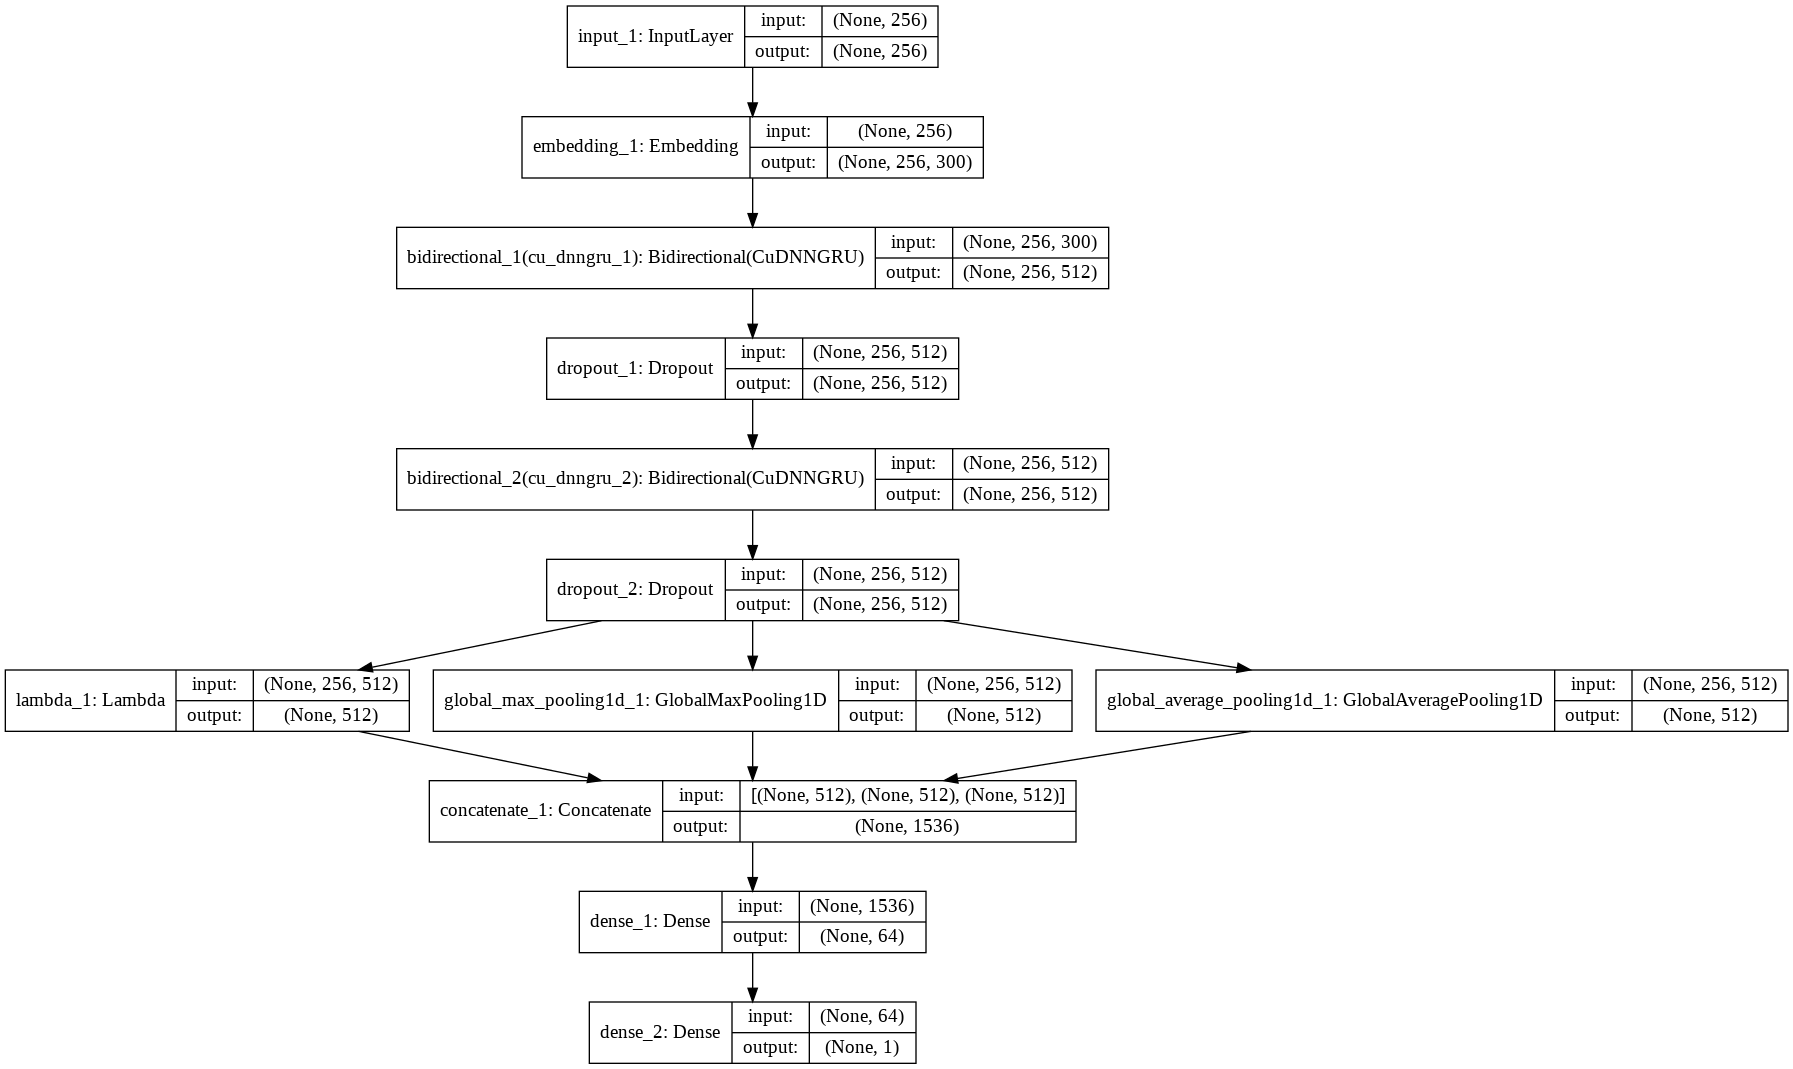

In [17]:
inp = Input(shape = (max_length, ))
x = Embedding(input_dim = vocab_size,
              output_dim = dim, 
              weights = [embedding_matrix], 
              trainable = True)(inp)

x = Bidirectional(CuDNNGRU(256,
                           kernel_regularizer=l2(alpha),
                           # bias_regularizer=l2(alpha),
                           return_sequences = True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(CuDNNGRU(256,
                           kernel_regularizer=l2(alpha),
                           # bias_regularizer=l2(alpha),
                           return_sequences = True))(x)
x = Dropout(0.5)(x)

max_pool = GlobalMaxPool1D()(x)
avg_pool = GlobalAveragePooling1D()(x)
last = Lambda(lambda x: x[:, 0, :])(x)
concat_pool = Concatenate(axis = -1)([last, max_pool, avg_pool])

op = Dense(64,
           kernel_regularizer=l2(alpha),
           # bias_regularizer=l2(alpha),
           activation = "relu")(concat_pool)
# op = Dropout(0.8)(op)
op = Dense(1, activation = "sigmoid")(op)

RNN = Model(inputs = inp, outputs = op)
RNN.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
# plot the model
plot_model(RNN, to_file=ROOT_PATH + 'resource/RNN_0102.png', show_shapes=True, show_layer_names=True)

## SARNN model

In [0]:
inp = Input(shape = (max_length, ))
x = Embedding(input_dim = vocab_size,
              output_dim = dim, 
              weights = [embedding_matrix], 
              trainable = True)(inp)

x = Bidirectional(LSTM(256, kernel_regularizer=l2(alpha), return_sequences = True))(x)
x = SeqSelfAttention(attention_regularizer_weight=1e-4)(x)
# x = LayerNormalization()(x)
x = Dropout(0.5)(x)

x = Bidirectional(LSTM(256, kernel_regularizer=l2(alpha), return_sequences = True))(x)
x = SeqWeightedAttention()(x)
# x = LayerNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = "sigmoid")(x)
SARNN = Model(inputs = inp, outputs = x)
SARNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [0]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
import keras.backend.tensorflow_backend as K

In [0]:
inp = Input(shape = (max_length, ))
x_words = Embedding(input_dim = vocab_size,
              output_dim = dim, 
              weights = [embedding_matrix], 
              trainable = False,
              mask_zero=True)(inp)
x_words = SpatialDropout1D(0.3)(x_words)
x_words = Bidirectional(LSTM(50, return_sequences=True))(x_words)
x_words = Attention(max_length)(x_words)
x_words = Dropout(0.2)(x_words)
x_words = Dense(50, activation='relu')(x_words)
x_words = Dropout(0.2)(x_words)
pred = Dense(5, activation='softmax')(x_words)

model = Model(inputs=inp, outputs=pred)

In [35]:
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 256)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 256, 300)          1789800   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 256, 300)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256, 100)          140400    
_________________________________________________________________
attention_4 (Attention)      (None, 100)               356       
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050

In [37]:
%%time
history = model.fit(X_train, y_train, epochs=10, verbose=1,batch_size=1024, shuffle=True,  validation_data=(X_val, y_val))

Train on 9168 samples, validate on 1019 samples
Epoch 1/10
9168/9168 [==============================] - 14s 1ms/step - loss: 0.4115 - acc: 0.8134 - val_loss: 0.3677 - val_acc: 0.8292
Epoch 2/10
9168/9168 [==============================] - 14s 2ms/step - loss: 0.3661 - acc: 0.8413 - val_loss: 0.3823 - val_acc: 0.8234
Epoch 3/10
9168/9168 [==============================] - 14s 1ms/step - loss: 0.3802 - acc: 0.8342 - val_loss: 0.3513 - val_acc: 0.8400
Epoch 4/10
9168/9168 [==============================] - 14s 2ms/step - loss: 0.3631 - acc: 0.8420 - val_loss: 0.3678 - val_acc: 0.8332
Epoch 5/10
9168/9168 [==============================] - 14s 2ms/step - loss: 0.3592 - acc: 0.8473 - val_loss: 0.3461 - val_acc: 0.8371
Epoch 6/10
9168/9168 [==============================] - 14s 2ms/step - loss: 0.3406 - acc: 0.8575 - val_loss: 0.3690 - val_acc: 0.8273
Epoch 7/10
9168/9168 [==============================] - 14s 2ms/step - loss: 0.3792 - acc: 0.8301 - val_loss: 0.3336 - val_acc: 0.8548
Epoch 8

## Train

In [0]:
model = RNN
model_name = 'RNN_0102.h5'

In [19]:
# fit the model
%%time
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5, verbose=1)



Train on 9168 samples, validate on 1019 samples
Epoch 1/5
9168/9168 [==============================] - 34s 4ms/step - loss: 2.0225 - acc: 0.8460 - val_loss: 0.3083 - val_acc: 0.8999
Epoch 2/5
9168/9168 [==============================] - 27s 3ms/step - loss: 0.2708 - acc: 0.9197 - val_loss: 0.3062 - val_acc: 0.9048
Epoch 3/5
9168/9168 [==============================] - 27s 3ms/step - loss: 0.2464 - acc: 0.9314 - val_loss: 0.4264 - val_acc: 0.9019
Epoch 4/5
9168/9168 [==============================] - 27s 3ms/step - loss: 0.2288 - acc: 0.9391 - val_loss: 0.3556 - val_acc: 0.8832
Epoch 5/5
9168/9168 [==============================] - 27s 3ms/step - loss: 0.1846 - acc: 0.9476 - val_loss: 0.2679 - val_acc: 0.9068
CPU times: user 1min 40s, sys: 20.5 s, total: 2min 1s
Wall time: 2min 22s


In [0]:
# fit the model with weight decay
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5, verbose=1)

Train on 9168 samples, validate on 1019 samples
Epoch 1/5
9168/9168 [==============================] - 624s 68ms/step - loss: 2.0775 - acc: 0.7538 - val_loss: 0.4978 - val_acc: 0.8636
Epoch 2/5
9168/9168 [==============================] - 610s 66ms/step - loss: 0.4303 - acc: 0.8766 - val_loss: 0.3279 - val_acc: 0.9019
Epoch 3/5
9168/9168 [==============================] - 620s 68ms/step - loss: 0.2851 - acc: 0.9234 - val_loss: 0.2816 - val_acc: 0.9127
Epoch 4/5
9168/9168 [==============================] - 620s 68ms/step - loss: 0.2516 - acc: 0.9365 - val_loss: 0.2985 - val_acc: 0.9107
Epoch 5/5
9168/9168 [==============================] - 602s 66ms/step - loss: 0.2245 - acc: 0.9462 - val_loss: 0.3947 - val_acc: 0.8930


In [0]:
model.save(ROOT_PATH + 'resource/' + model_name)

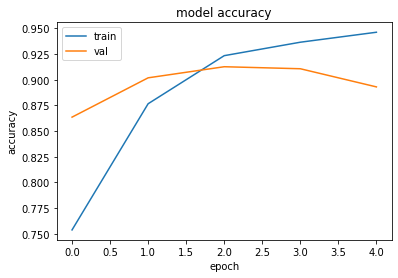

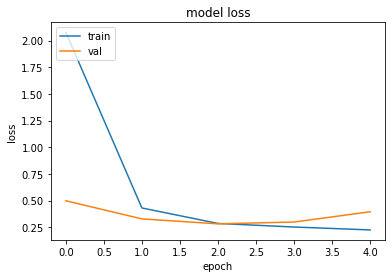

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## Test

In [20]:
X_test = test.content.tolist()
y_test = np.array(test.ground)
len(X_test), y_test.shape

(1552, (1552,))

In [21]:
X_test, _, _ = make_padded_docs(X_test,
                            max_length,
                            t)

padded_docs shape: (1552, 256)


In [22]:
y_pred = model.predict(X_test, verbose=1).round()
y_pred

1552/1552 [==============================] - 2s 1ms/step


array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [23]:
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.90      0.85      0.88       758
    positive       0.87      0.91      0.89       794

    accuracy                           0.88      1552
   macro avg       0.88      0.88      0.88      1552
weighted avg       0.88      0.88      0.88      1552



In [0]:
print('Ground\tPred\tText')
for i in range(10):
    print(str(y_test[i]) + '\t' + str(int(y_pred[i][0])) + '\t' + test.content.tolist()[i])

Ground	Pred	Text
0	0	sản phẩm hay bị đơ dùng pin hao nhanh hỗ trợ sạc nhanh ko thật sự hiệu quả chụp ảnh chỉ dừng ở mức chập nhận đc ko lung linh như hãng khác cùng tầm giá
1	1	đẹp nhất cấu hình cao nhất pin trâu nhất trong tầm giá rất hợp với một kiến trúc sư
1	1	trên cả tuyệt vời pin trâu mượt sang trọng không rời em nó nửa bước cây bút dễ dùng
0	1	sản phẩm tầm trung xài tạm ổn nói chung sản phâm bình thường không có ưu điểm nổi bât
1	1	oppo neo thật quá đã tính năng cũng như hđh phù hợp với giới trẻ hiện nay nhưng giá cả nê giảm lại một chút nữa thì bán chạy hơn nhiều
0	0	lúc đầu mình sử dụng cũng hay bị lõi nhưng khi cập nhật phần mềm vá lỗi thì ok với mức giá tôi không thích ghét cái sóng mạng rất yếu nhất là cái phần mềm nâng cấp nó làm mất đi chức năng tiện lợi hữu ít lúc đầu như chỉnh độ sáng đen pin chỉnh máy ảnh v v lúc trước nói đến samsung là nói đến chất lượng tôi không hiểu sao samsung càng ngày càng tệ bó tay luôn
1	1	mới mua hồi sáng về chơi tới giờ pin còn hơn đúng trâ